In [1]:
# JAX vs PyTorch Track Prediction Comparison
# This notebook compares raw forward pass outputs (no post-processing)
# Pattern follows the integration tests for accurate comparison

import os
from dotenv import load_dotenv
load_dotenv()

import time
import numpy as np
import torch
import jax
import jax.numpy as jnp
import haiku as hk
import jmp
import matplotlib.pyplot as plt

from alphagenome_research.model import dna_model
from alphagenome_research.model import model as model_lib
from alphagenome_research.model import dna_model as dna_model_lib
from alphagenome_pytorch import AlphaGenome, set_update_running_var
from alphagenome_pytorch.convert.convert_checkpoint import (
    convert_checkpoint, flatten_nested_dict
)

print(f"JAX devices: {jax.devices()}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"HF_TOKEN set: {bool(os.environ.get('HF_TOKEN'))}")

/homes/gws/tuxm/Project/alphagenome/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


JAX devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]
CUDA available: True
HF_TOKEN set: True


In [2]:
# Load JAX model (will be used for BOTH conversion and comparison)
# This matches the integration test pattern

print("Loading JAX model...")
jax_device = jax.devices("gpu")[0]  # Use first GPU for JAX
jax_model = dna_model.create_from_huggingface('all_folds', device=jax_device)
print(f"JAX model loaded on device: {jax_device}")

Loading JAX model...


Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 108007.83it/s]
/homes/gws/tuxm/Project/alphagenome/.venv/lib/python3.11/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)
/homes/gws/tuxm/Project/alphagenome/.venv/lib/python3.11/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


JAX model loaded on device: cuda:0


In [3]:
# Convert JAX checkpoint to PyTorch using the SAME model instance
# This ensures params match exactly

print("Converting checkpoint from loaded JAX model...")
flat_params = flatten_nested_dict(jax_model._params)
flat_state = flatten_nested_dict(jax_model._state)

state_dict = convert_checkpoint(flat_params, flat_state, verbose=True)
print(f"Converted {len(state_dict)} tensors")

Converting checkpoint from loaded JAX model...

Converting 545 parameter mappings...
Converting 81 state mappings...

Converted 653 tensors to PyTorch state_dict
Converted 653 tensors


In [4]:
# Create PyTorch model with reference heads

print("Creating PyTorch model...")
torch_device = torch.device("cuda:1" if torch.cuda.device_count() > 1 else "cuda:0")

model = AlphaGenome()
model.add_reference_heads('human')  # Add heads BEFORE loading weights
model.load_state_dict(state_dict, strict=False)
model = model.to(torch_device)
model.eval()
set_update_running_var(model, False)

print(f"PyTorch model on device: {torch_device}")
print(f"Total parameters: {model.total_parameters:,}")

Creating PyTorch model...
PyTorch model on device: cuda:1
Total parameters: 427,154,310


In [5]:
# Build JAX apply function (same pattern as integration tests)
# IMPORTANT: Define outside any jax.default_device() context

metadata = jax_model._metadata
model_settings = dna_model_lib.ModelSettings()
jmp_policy = jmp.get_policy('params=float32,compute=float32,output=float32')

@hk.transform_with_state
def _forward(dna_sequence, organism_index):
    with hk.mixed_precision.push_policy(model_lib.AlphaGenome, jmp_policy):
        return model_lib.AlphaGenome(
            metadata,
            num_splice_sites=model_settings.num_splice_sites,
            splice_site_threshold=model_settings.splice_site_threshold,
        )(dna_sequence, organism_index)

def jax_apply_fn(params, state, dna_sequence, organism_index):
    """Returns predictions dict (like integration tests jax_heads_apply_fn)."""
    (preds, _), _ = _forward.apply(params, state, None, dna_sequence, organism_index)
    return preds

print("JAX apply function built")

JAX apply function built


In [6]:
# Prepare test input using REAL genomic sequence (same as load_model.ipynb)

from alphagenome.data import genome
from alphagenome_research.io.fasta import FastaExtractor

# Define genomic interval (same as load_model.ipynb)
interval = genome.Interval(
    chromosome='chr22',
    start=36201698 - 2**14,  # 16384 bp before
    end=36201698 + 2**14     # 16384 bp after
)

variant = genome.Variant(
    chromosome='chr22',
    position=36201698,
    reference_bases='A',
    alternate_bases='C',
)

print(f"Interval: {interval}")
print(f"Interval size: {interval.end - interval.start} bp")
print(f"Variant: {variant}")

# Fetch DNA sequence using FastaExtractor
fasta_url = 'https://storage.googleapis.com/alphagenome/reference/gencode/hg38/GRCh38.p13.genome.fa'
fasta_extractor = FastaExtractor(fasta_url)
dna_seq = fasta_extractor.extract(interval)

print(f"Fetched sequence length: {len(dna_seq)} bp")
print(f"First 50 bp: {dna_seq[:50]}")

# Encode DNA to integers (A=0, C=1, G=2, T=3)
def encode_dna(seq: str) -> np.ndarray:
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3, 'N': 0,
               'a': 0, 'c': 1, 'g': 2, 't': 3, 'n': 0}
    return np.array([mapping.get(c, 0) for c in seq], dtype=np.int64)  # int64 for PyTorch

seq_np = encode_dna(dna_seq).reshape(1, -1)  # [1, seq_len]
SEQ_LEN = seq_np.shape[1]
BATCH_SIZE = 1

print(f"\\nInput sequence shape: {seq_np.shape}")
print(f"Encoded preview: {seq_np[0, :20]}")

Interval: chr22:36185314-36218082:.
Interval size: 32768 bp
Variant: chr22:36201698:A>C


/homes/gws/tuxm/Project/alphagenome/.venv/lib/python3.11/site-packages/pyfaidx/__init__.py:589: UserWarning: for fsspec: HTTPFileSystem assuming index is current
  warnings.warn("for fsspec: %s assuming index is current" % type(self._fs).__name__)


Fetched sequence length: 32768 bp
First 50 bp: AAGTTCAGCATTTTAGAAGGAATACGTCTGGAGGCTTGGTGACAAAGATA
\nInput sequence shape: (1, 32768)
Encoded preview: [0 0 2 3 3 1 0 2 1 0 3 3 3 3 0 2 0 0 2 2]


In [7]:
# Run JAX forward pass

# Convert to one-hot for JAX
seq_onehot = jnp.eye(4, dtype=jnp.float32)[seq_np]  # [B, S, 4]
organism_jax = jnp.zeros((BATCH_SIZE,), dtype=jnp.int32)  # human=0

print("Running JAX forward pass...")
start_time = time.time()
jax_preds = jax_apply_fn(
    jax_model._params,
    jax_model._state,
    seq_onehot,
    organism_jax,
)
jax_time = time.time() - start_time
print(f"JAX inference time: {jax_time:.2f} seconds")

# Extract outputs
jax_outputs = {
    'rna_seq_1bp': np.asarray(jax_preds['rna_seq']['scaled_predictions_1bp']),
    'rna_seq_128bp': np.asarray(jax_preds['rna_seq']['scaled_predictions_128bp']),
    'contact_maps': np.asarray(jax_preds['contact_maps']['predictions']),
}

print(f"\nJAX output shapes:")
for name, arr in jax_outputs.items():
    has_nan = np.isnan(arr).any()
    print(f"  {name}: {arr.shape}, NaN: {has_nan}")

Running JAX forward pass...
JAX inference time: 71.30 seconds

JAX output shapes:
  rna_seq_1bp: (1, 32768, 768), NaN: False
  rna_seq_128bp: (1, 256, 768), NaN: False
  contact_maps: (1, 16, 16, 28), NaN: False


In [8]:
# Run PyTorch forward pass

seq_torch = torch.from_numpy(seq_np).to(torch_device)
organism_torch = torch.zeros(BATCH_SIZE, dtype=torch.long, device=torch_device)

print("Running PyTorch forward pass...")
start_time = time.time()
with torch.no_grad():
    torch_out = model(seq_torch, organism_torch)
pytorch_time = time.time() - start_time
print(f"PyTorch inference time: {pytorch_time:.2f} seconds")

# Extract outputs
torch_heads = torch_out['human']
torch_outputs = {
    'rna_seq_1bp': torch_heads['rna_seq']['scaled_predictions_1bp'].cpu().numpy(),
    'rna_seq_128bp': torch_heads['rna_seq']['scaled_predictions_128bp'].cpu().numpy(),
    'contact_maps': torch_heads['contact_maps'].cpu().numpy(),
}

print(f"\nPyTorch output shapes:")
for name, arr in torch_outputs.items():
    has_nan = np.isnan(arr).any()
    print(f"  {name}: {arr.shape}, NaN: {has_nan}")

Running PyTorch forward pass...
PyTorch inference time: 0.60 seconds

PyTorch output shapes:
  rna_seq_1bp: (1, 32768, 768), NaN: False
  rna_seq_128bp: (1, 256, 768), NaN: False
  contact_maps: (1, 16, 16, 28), NaN: False


In [9]:
# Compare JAX vs PyTorch outputs

def compare_arrays(name, jax_arr, torch_arr, atol=1e-2, rtol=1e-2):
    """Compare two arrays and print statistics."""
    jax_flat = jax_arr.flatten().astype(np.float64)
    torch_flat = torch_arr.flatten().astype(np.float64)
    
    # Check for NaN
    jax_nan = np.isnan(jax_flat).sum()
    torch_nan = np.isnan(torch_flat).sum()
    
    if jax_nan > 0 or torch_nan > 0:
        print(f"\n{name}:")
        print(f"  WARNING: NaN values - JAX: {jax_nan}, PyTorch: {torch_nan}")
        return None
    
    # Statistics
    within_tolerance = np.abs(jax_flat - torch_flat) <= (atol + rtol * np.abs(jax_flat))
    fraction_within = np.mean(within_tolerance)
    
    correlation = np.corrcoef(jax_flat, torch_flat)[0, 1]
    max_diff = np.abs(jax_flat - torch_flat).max()
    mean_diff = np.abs(jax_flat - torch_flat).mean()
    
    print(f"\n{name}:")
    print(f"  Shape: {jax_arr.shape}")
    print(f"  JAX stats: mean={jax_flat.mean():.6f}, max={jax_flat.max():.4f}, min={jax_flat.min():.4f}")
    print(f"  PyTorch stats: mean={torch_flat.mean():.6f}, max={torch_flat.max():.4f}, min={torch_flat.min():.4f}")
    print(f"  Within tolerance (atol={atol}, rtol={rtol}): {fraction_within*100:.2f}%")
    print(f"  Pearson correlation: {correlation:.6f}")
    print(f"  Max abs diff: {max_diff:.6f}")
    print(f"  Mean abs diff: {mean_diff:.6f}")
    
    return {
        'fraction_within': fraction_within,
        'correlation': correlation,
        'max_diff': max_diff,
        'mean_diff': mean_diff,
    }

print("="*60)
print("JAX vs PyTorch Comparison (Raw Forward Pass)")
print("="*60)

results = {}
for name in jax_outputs.keys():
    results[name] = compare_arrays(name, jax_outputs[name], torch_outputs[name])

JAX vs PyTorch Comparison (Raw Forward Pass)

rna_seq_1bp:
  Shape: (1, 32768, 768)
  JAX stats: mean=0.266723, max=20.6579, min=0.0000
  PyTorch stats: mean=0.266827, max=20.6724, min=0.0000
  Within tolerance (atol=0.01, rtol=0.01): 100.00%
  Pearson correlation: 1.000000
  Max abs diff: 0.037008
  Mean abs diff: 0.000147

rna_seq_128bp:
  Shape: (1, 256, 768)
  JAX stats: mean=0.272918, max=21.5726, min=0.0000
  PyTorch stats: mean=0.273028, max=21.5818, min=0.0000
  Within tolerance (atol=0.01, rtol=0.01): 100.00%
  Pearson correlation: 1.000000
  Max abs diff: 0.043787
  Mean abs diff: 0.000161

contact_maps:
  Shape: (1, 16, 16, 28)
  JAX stats: mean=-0.254744, max=0.3028, min=-5.1523
  PyTorch stats: mean=-0.254722, max=0.3028, min=-5.1523
  Within tolerance (atol=0.01, rtol=0.01): 100.00%
  Pearson correlation: 1.000000
  Max abs diff: 0.002131
  Mean abs diff: 0.000101


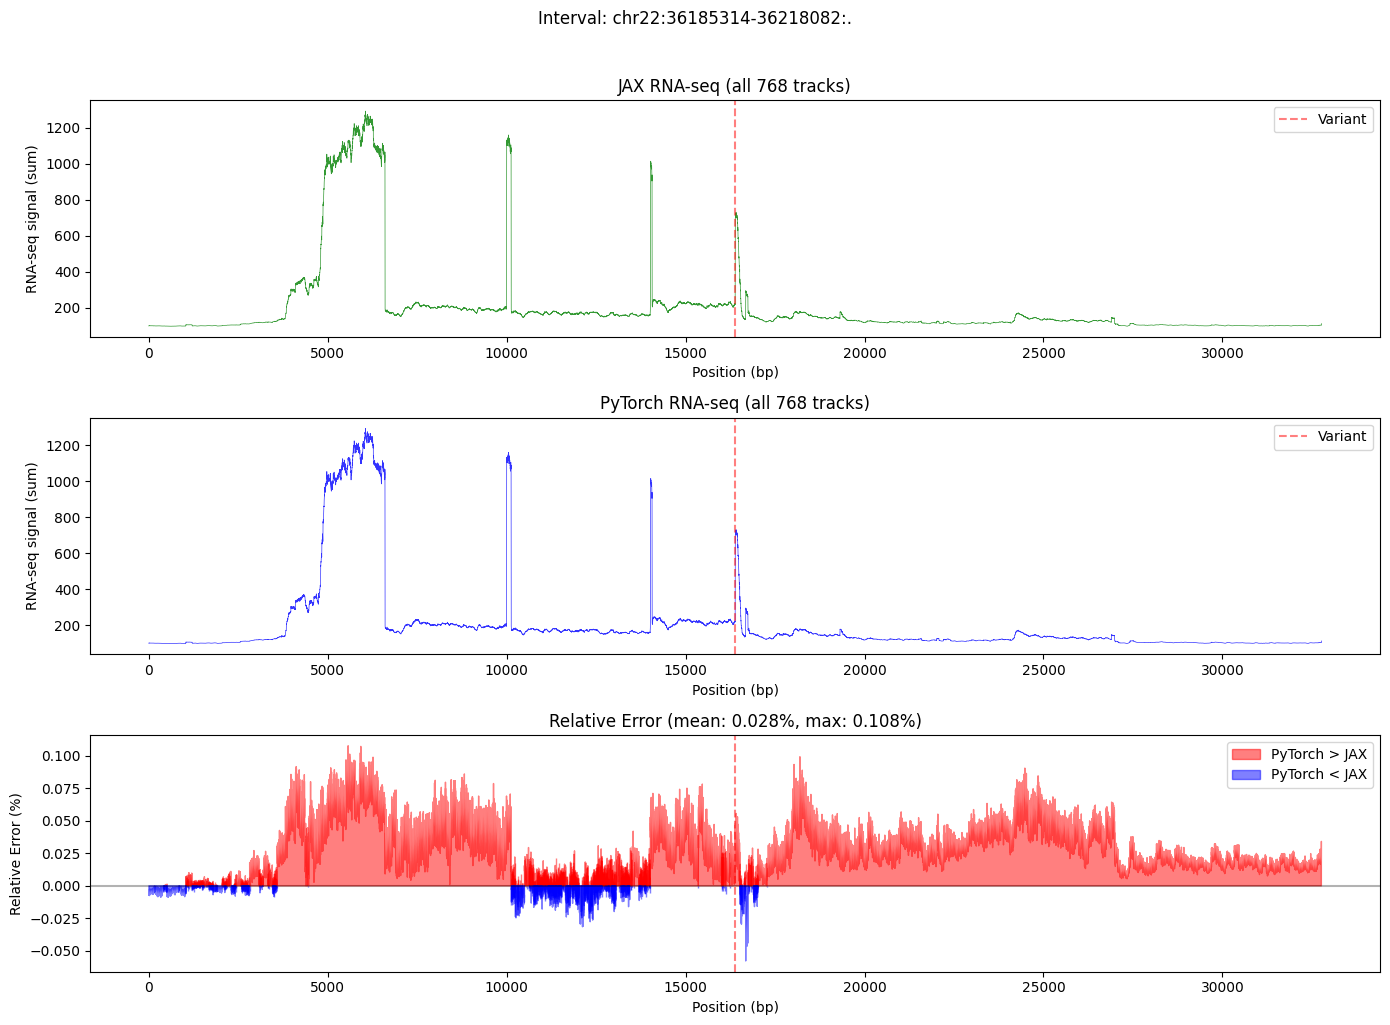

In [10]:
# Visualize RNA-seq 1bp comparison

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Sum across tracks for visualization
jax_signal = jax_outputs['rna_seq_1bp'][0].sum(axis=1)
torch_signal = torch_outputs['rna_seq_1bp'][0].sum(axis=1)

# Variant position in sequence
var_pos = variant.position - interval.start

# Plot 1: JAX RNA-seq signal
ax1 = axes[0]
ax1.plot(jax_signal, color='green', alpha=0.8, linewidth=0.5)
ax1.axvline(x=var_pos, color='red', linestyle='--', alpha=0.5, label='Variant')
ax1.set_xlabel('Position (bp)')
ax1.set_ylabel('RNA-seq signal (sum)')
ax1.set_title('JAX RNA-seq (all 768 tracks)')
ax1.legend()

# Plot 2: PyTorch RNA-seq signal
ax2 = axes[1]
ax2.plot(torch_signal, color='blue', alpha=0.8, linewidth=0.5)
ax2.axvline(x=var_pos, color='red', linestyle='--', alpha=0.5, label='Variant')
ax2.set_xlabel('Position (bp)')
ax2.set_ylabel('RNA-seq signal (sum)')
ax2.set_title('PyTorch RNA-seq (all 768 tracks)')
ax2.legend()

# Plot 3: Relative error (as percentage)
ax3 = axes[2]
# Compute relative error, avoiding division by zero
relative_error = np.where(
    np.abs(jax_signal) > 1e-6,
    (torch_signal - jax_signal) / np.abs(jax_signal) * 100,
    0
)
ax3.fill_between(range(len(relative_error)), relative_error, where=(relative_error > 0),
                 color='red', alpha=0.5, label='PyTorch > JAX')
ax3.fill_between(range(len(relative_error)), relative_error, where=(relative_error < 0),
                 color='blue', alpha=0.5, label='PyTorch < JAX')
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax3.axvline(x=var_pos, color='red', linestyle='--', alpha=0.5)
ax3.set_xlabel('Position (bp)')
ax3.set_ylabel('Relative Error (%)')
ax3.set_title(f'Relative Error (mean: {np.abs(relative_error).mean():.3f}%, max: {np.abs(relative_error).max():.3f}%)')
ax3.legend()

plt.suptitle(f'Interval: {interval}', y=1.02)
plt.tight_layout()
plt.show()


In [11]:
# Summary

print("="*60)
print("Summary")
print("="*60)

print(f"\nInference times:")
print(f"  JAX: {jax_time:.2f} seconds")
print(f"  PyTorch: {pytorch_time:.2f} seconds")
print(f"  Speedup: {jax_time/pytorch_time:.1f}x")

print(f"\nAgreement summary (target: >= 99%):")
all_pass = True
for name, stats in results.items():
    if stats is None:
        print(f"  {name}: FAILED (NaN values)")
        all_pass = False
    else:
        passed = stats['fraction_within'] >= 0.99
        status = "PASS" if passed else "FAIL"
        print(f"  {name}: {stats['fraction_within']*100:.2f}% [{status}]")
        if not passed:
            all_pass = False

print(f"\nOverall: {'PASS' if all_pass else 'FAIL'}")

Summary

Inference times:
  JAX: 71.30 seconds
  PyTorch: 0.60 seconds
  Speedup: 118.9x

Agreement summary (target: >= 99%):
  rna_seq_1bp: 100.00% [PASS]
  rna_seq_128bp: 100.00% [PASS]
  contact_maps: 100.00% [PASS]

Overall: PASS
